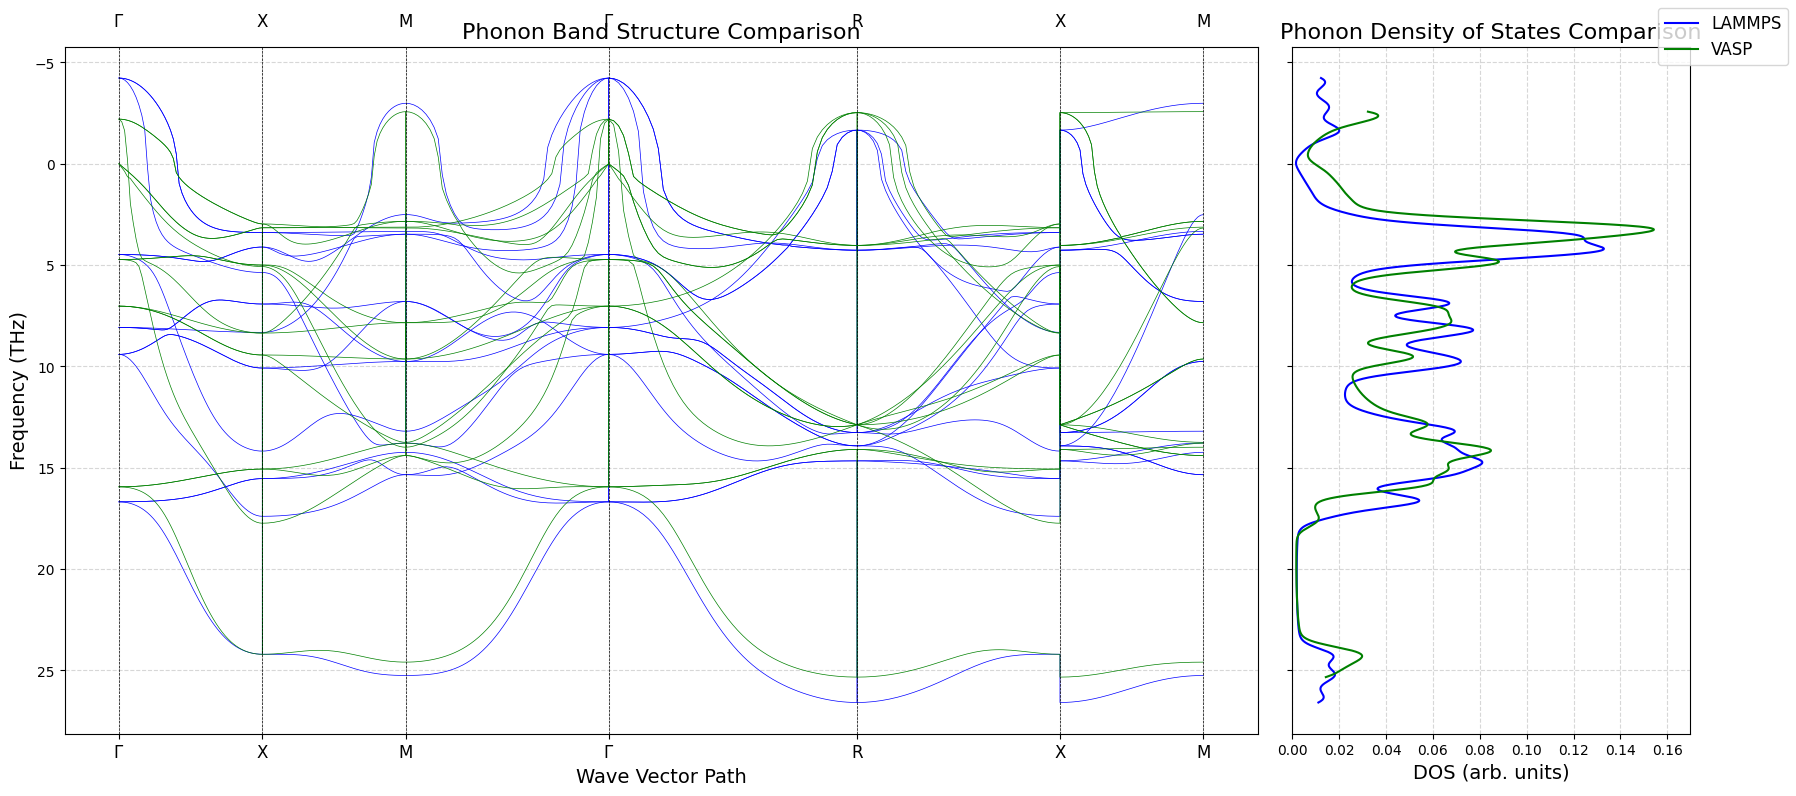

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from collections import OrderedDict

def calculate_path_length(qpoints, segment_nqpoint):
    """
    计算每个 q 点在路径上的累积距离。
    """
    path_length = [0]
    current_index = 0
    for nq in segment_nqpoint:
        for i in range(current_index, current_index + nq - 1):
            delta = np.linalg.norm(np.array(qpoints[i + 1]) - np.array(qpoints[i]))
            path_length.append(path_length[-1] + delta)
        current_index += nq
    return path_length

def extract_phonon_data(band_yaml_path, dos_sigma):
    """
    读取 band.yaml 文件并提取声子频率和距离数据。
    
    参数:
    - band_yaml_path: str, band.yaml 文件的路径
    - dos_sigma: float, 用于核密度估计的标准差，控制 DOS 的平滑程度
    
    返回:
    - data_dict: dict, 包含距离、频率、标签等信息
    """
    with open(band_yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    
    # 提取基本信息
    nqpoint = data.get('nqpoint', 0)
    npath = data.get('npath', 0)
    segment_nqpoint = data.get('segment_nqpoint', [])
    labels_segments = data.get('labels', [])
    frequency_conversion = data.get('frequency_unit_conversion_factor', 1.0)
    
    # 提取 q 点信息
    phonon_data = data.get('phonon', [])
    
    if len(phonon_data) == 0:
        raise ValueError(f"{band_yaml_path} 中的 phonon 数据为空，请检查文件内容。")
    
    # 获取声子数目
    nbands = len(phonon_data[0]['band'])
    
    # 初始化数组
    frequencies = np.zeros((nqpoint, nbands))
    distances = []
    
    # 填充距离和频率
    for i, qpoint in enumerate(phonon_data):
        distances.append(qpoint['distance'])
        for band_idx, band in enumerate(qpoint['band']):
            frequencies[i, band_idx] = band['frequency'] * frequency_conversion  # 转换单位
    
    distances = np.array(distances)
    
    # 计算高对称点的位置和标签
    high_symmetry_distances = []
    high_symmetry_labels = []
    current = 0
    high_symmetry_distances.append(distances[0])
    high_symmetry_labels.append(labels_segments[0][0])  # 第一个高对称点标签
    
    for idx, nq in enumerate(segment_nqpoint):
        if idx < len(labels_segments):
            # 每个段的结束点对应下一个段的起始高对称点
            current += nq
            if current < len(distances):
                high_symmetry_distances.append(distances[current - 1])
                high_symmetry_labels.append(labels_segments[idx][1])
    
    # 确保最后一个高对称点被添加
    if high_symmetry_distances[-1] != distances[-1]:
        high_symmetry_distances.append(distances[-1])
        high_symmetry_labels.append(labels_segments[-1][1])
    
    # 计算 DOS
    all_frequencies = frequencies.flatten()
    
    # 处理负频率（根据需求保留或去除）
    # 通常，负频率表示不稳定模式。这里我们保留所有频率，包括负值。
    # 如果只关心正频率，可以取消下面的注释。
    # all_frequencies = all_frequencies[all_frequencies > 0]
    
    # 使用核密度估计计算 DOS
    kde = gaussian_kde(all_frequencies, bw_method=dos_sigma)
    frequency_range = np.linspace(all_frequencies.min(), all_frequencies.max(), 1000)
    dos = kde(frequency_range)
    
    data_dict = {
        'distances': distances,
        'frequencies': frequencies,
        'high_symmetry_distances': high_symmetry_distances,
        'high_symmetry_labels': high_symmetry_labels,
        'frequency_range': frequency_range,
        'dos': dos
    }
    
    return data_dict

def plot_comparison(band_yaml_paths, labels, colors, dos_sigma=0.1):
    """
    绘制多个 band.yaml 文件的声子带结构和 DOS 进行对比。
    
    参数:
    - band_yaml_paths: list of str, band.yaml 文件的路径列表
    - labels: list of str, 每个文件对应的标签，用于图例
    - colors: list of str, 每个文件对应的颜色，用于区分
    - dos_sigma: float, 用于核密度估计的标准差，控制 DOS 的平滑程度
    """
    if not (len(band_yaml_paths) == len(labels) == len(colors)):
        raise ValueError("band_yaml_paths, labels, colors 的长度必须相同。")
    
    # 初始化图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
    
    # 初始化列表存储所有数据
    data_list = []
    
    for path, label, color in zip(band_yaml_paths, labels, colors):
        data = extract_phonon_data(path, dos_sigma)
        data_list.append(data)
        
        # 绘制声子带结构
        for band in range(data['frequencies'].shape[1]):
            if band == 0:
                ax1.plot(data['distances'], data['frequencies'][:, band], color=color, linewidth=0.5, label=label)
            else:
                ax1.plot(data['distances'], data['frequencies'][:, band], color=color, linewidth=0.5)
        
        # 绘制 DOS
        ax2.plot(data['dos'], data['frequency_range'], color=color, linewidth=1.5, label=label)
    
    # 使用第一个文件的高对称点信息
    if data_list:
        first_data = data_list[0]
        for d, lbl in zip(first_data['high_symmetry_distances'], first_data['high_symmetry_labels']):
            ax1.axvline(x=d, color='k', linestyle='--', linewidth=0.5)
            ax1.text(d, ax1.get_ylim()[0] - (ax1.get_ylim()[1]-ax1.get_ylim()[0])*0.05, lbl, 
                     horizontalalignment='center', verticalalignment='top', fontsize=12)
    
    # 设置 x 轴刻度
    if data_list:
        ax1.set_xticks(first_data['high_symmetry_distances'])
        ax1.set_xticklabels(first_data['high_symmetry_labels'], fontsize=12)
    
    # 设置标签和标题
    ax1.set_xlabel('Wave Vector Path', fontsize=14)
    ax1.set_ylabel('Frequency (THz)', fontsize=14)
    ax1.set_title('Phonon Band Structure Comparison', fontsize=16)
    
    # 设置 y 轴的范围，考虑负频率
    y_min = min([data['frequencies'].min() for data in data_list] + [0])
    y_max = max([data['frequencies'].max() for data in data_list] + [0])
    ax1.set_ylim(y_min - (y_max - y_min)*0.05, y_max + (y_max - y_min)*0.05)
    
    # 添加网格
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # 设置 DOS 图
    # 频率从上到下递增
    ax2.set_ylim(ax1.get_ylim())
    ax2.invert_yaxis()
    
    # 设置 x 轴的范围
    dos_max = max([data['dos'].max() for data in data_list])
    ax2.set_xlim(0, dos_max * 1.1)
    
    # 设置 DOS 的标签和标题
    ax2.set_xlabel('DOS (arb. units)', fontsize=14)
    ax2.set_title('Phonon Density of States Comparison', fontsize=16)
    
    # 添加网格
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # 添加图例
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels_combined = labels1 + labels2
    # 使用 OrderedDict 去除重复标签
    by_label = OrderedDict(zip(labels_combined, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=12)
    
    # 调整子图之间的间距
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    
    # 显示图形
    plt.show()

if __name__ == "__main__":
    # 指定 band.yaml 文件的路径
    band_yaml_paths = ['band-lmp.yaml', 'band-vasp.yaml']  # 两个输入文件
    labels = ['LAMMPS', 'VASP']  # 对应的标签
    colors = ['blue', 'green']  # 对应的颜色
    
    # 绘制声子带结构和 DOS 比较
    plot_comparison(band_yaml_paths, labels, colors, dos_sigma=0.05)
